In [ ]:
# Expanded adversarial experiments for MNIST: adversarial training, transferability, PGD-steps ablation
# Paste into a Colab cell and run. Uses GPU if available.

# ===== 0. Imports, config, helpers =====
import os, random, math, time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

%matplotlib inline

# Config
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

OUTPUT_DIR = "outputs_adv"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparams (you can tweak)
BATCH_SIZE = 128
TEST_BATCH = 256
EPOCHS_CLEAN = 5           # epochs for baseline model
EPOCHS_ADV = 6             # epochs for adversarial training (a bit longer)
LR = 1e-3

# Attack configs
EPS_LIST = [0.05, 0.15, 0.25]
PGD_STEPS = 40
PGD_ALPHA = 0.01

# For ablation experiment
PGD_STEPS_LIST = [5, 10, 20, 40]

# ===== 1. Data: MNIST =====
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=TEST_BATCH, shuffle=False, num_workers=2, pin_memory=True)

# ===== 2. Models =====
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.fc1   = nn.Linear(64*14*14, 128)
        self.fc2   = nn.Linear(128, 10)
        self.drop  = nn.Dropout(0.25)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(self.drop(x)))
        x = self.fc2(x)
        return x

class AdvCNN(nn.Module):
    """Slightly deeper model for comparison"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # 32x28x28
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 64x28x28
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 128x28x28
        self.pool  = nn.MaxPool2d(2,2)                # -> 128x14x14
        self.fc1   = nn.Linear(128*14*14, 256)
        self.fc2   = nn.Linear(256, 10)
        self.drop  = nn.Dropout(0.3)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(self.drop(x)))
        x = self.fc2(x)
        return x

# instantiate
model_clean = SimpleCNN().to(DEVICE)   # baseline
model_adv = AdvCNN().to(DEVICE)        # will be adversarially trained (robust model)

# ===== 3. Training & eval helpers =====
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss/total, total_correct/total

def eval_model(model, loader, device):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total += x.size(0)
    return total_loss/total, total_correct/total

# ===== 4. Attack functions (FGSM and PGD) =====
def fgsm_attack(model, x, y, eps, targeted=False, target_label=None):
    x_adv = x.clone().detach().to(DEVICE)
    x_adv.requires_grad = True
    model.zero_grad()
    outputs = model(x_adv)
    if targeted:
        assert target_label is not None
        loss = criterion(outputs, target_label.to(DEVICE))
        loss.backward()
        grad = x_adv.grad.data
        perturbed = x_adv - eps * grad.sign()
    else:
        loss = criterion(outputs, y.to(DEVICE))
        loss.backward()
        grad = x_adv.grad.data
        perturbed = x_adv + eps * grad.sign()
    return torch.clamp(perturbed.detach(), 0.0, 1.0)

def pgd_attack(model, x, y, eps, alpha=PGD_ALPHA, iters=PGD_STEPS, targeted=False, target_label=None):
    model.eval()
    x0 = x.clone().detach().to(DEVICE)
    perturbed = x0 + torch.empty_like(x0).uniform_(-eps, eps)
    perturbed = torch.clamp(perturbed, 0.0, 1.0)
    for _ in range(iters):
        perturbed.requires_grad = True
        outputs = model(perturbed)
        model.zero_grad()
        if targeted:
            assert target_label is not None
            loss = criterion(outputs, target_label.to(DEVICE))
            loss.backward()
            grad = perturbed.grad.data
            perturbed = perturbed - alpha * grad.sign()
        else:
            loss = criterion(outputs, y.to(DEVICE))
            loss.backward()
            grad = perturbed.grad.data
            perturbed = perturbed + alpha * grad.sign()
        # project
        perturbed = torch.max(torch.min(perturbed, x0 + eps), x0 - eps)
        perturbed = torch.clamp(perturbed.detach(), 0.0, 1.0)
    return perturbed

# batch wrappers
def fgsm_batch(model, x, y, eps, targeted=False, target_label=None):
    return fgsm_attack(model, x, y, eps, targeted=targeted, target_label=target_label)

def pgd_batch(model, x, y, eps, targeted=False, target_label=None, iters=PGD_STEPS):
    return pgd_attack(model, x, y, eps, alpha=PGD_ALPHA, iters=iters, targeted=targeted, target_label=target_label)

# ===== 5. Baseline training (clean) =====
print("=== Training baseline model (clean) ===")
opt_clean = optim.Adam(model_clean.parameters(), lr=LR)
for epoch in range(1, EPOCHS_CLEAN+1):
    tr_loss, tr_acc = train_one_epoch(model_clean, train_loader, opt_clean, DEVICE)
    te_loss, te_acc = eval_model(model_clean, test_loader, DEVICE)
    print(f"[Clean] Epoch {epoch}/{EPOCHS_CLEAN} | Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")

# save baseline
torch.save(model_clean.state_dict(), os.path.join(OUTPUT_DIR, "model_clean.pth"))

# ===== 6. Adversarial training (PGD-based) =====
# We perform Madry-style adversarial training: on each batch generate PGD untargeted adversarial x_adv for current model and train on x_adv.

def adv_train_one_epoch(model, loader, optimizer, device, eps, iters=PGD_STEPS, alpha=PGD_ALPHA):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        # generate adversarial examples on current model (with no_grad? need grads to craft, but attack returns detached)
        x_adv = pgd_attack(model, x, y, eps=eps, alpha=alpha, iters=iters, targeted=False)
        optimizer.zero_grad()
        out = model(x_adv)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss/total, total_correct/total

# Adversarial training: use PGD with eps = typical value (we'll use 0.25 as a strong robust baseline)
ADV_EPS = 0.25
print("\n=== Starting adversarial training (PGD eps=%.3f, steps=%d) ===" % (ADV_EPS, PGD_STEPS))
opt_adv = optim.Adam(model_adv.parameters(), lr=LR)
for epoch in range(1, EPOCHS_ADV+1):
    tr_loss, tr_acc = adv_train_one_epoch(model_adv, train_loader, opt_adv, DEVICE, eps=ADV_EPS, iters=PGD_STEPS, alpha=PGD_ALPHA)
    te_loss_clean, te_acc_clean = eval_model(model_adv, test_loader, DEVICE)
    # evaluate robust accuracy (on PGD adversarial examples)
    # generate adversarial testset batchwise and evaluate
    def robust_eval(model, loader, eps, iters):
        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for x,y in loader:
                x,y = x.to(DEVICE), y.to(DEVICE)
                xadv = pgd_attack(model, x, y, eps=eps, alpha=PGD_ALPHA, iters=iters, targeted=False)
                out = model(xadv)
                preds = out.argmax(dim=1)
                total += x.size(0)
                correct += (preds == y).sum().item()
        return correct/total
    robust_acc = robust_eval(model_adv, test_loader, ADV_EPS, PGD_STEPS)
    print(f"[AdvTrain] Epoch {epoch}/{EPOCHS_ADV} | Train Acc(on adv) {tr_acc:.4f} | Test Clean Acc: {te_acc_clean:.4f} | Robust Acc (PGD eps={ADV_EPS}): {robust_acc:.4f}")

# save adv-trained model
torch.save(model_adv.state_dict(), os.path.join(OUTPUT_DIR, "model_adv.pth"))

# ===== 7. Evaluate: clean, FGSM & PGD for both models across EPS_LIST =====
def eval_attack_on_loader(model, loader, attack_fn, eps, targeted=False, target_fn=None, iters=PGD_STEPS):
    model.eval()
    total, correct_orig = 0, 0
    total_target_correct = 0
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        if targeted:
            target_labels = target_fn(y)
            xadv = attack_fn(model, x, y, eps, targeted=True, target_label=target_labels) if attack_fn==fgsm_batch else attack_fn(model, x, y, eps, targeted=True, target_label=target_labels, iters=iters)
        else:
            xadv = attack_fn(model, x, y, eps, targeted=False) if attack_fn==fgsm_batch else attack_fn(model, x, y, eps, targeted=False, iters=iters)
        with torch.no_grad():
            out = model(xadv)
            preds = out.argmax(dim=1)
        total += x.size(0)
        correct_orig += (preds == y).sum().item()
        if targeted:
            total_target_correct += (preds == target_labels.to(DEVICE)).sum().item()
    acc_orig = correct_orig/total
    acc_target = (total_target_correct/total) if targeted else None
    return acc_orig, acc_target

def next_label(y):
    return ((y + 1) % 10).to(torch.long)

def evaluate_models(models, labels):
    # models: dict name -> model
    results = {}
    for name, m in models.items():
        results[name] = {}
        # clean acc
        _, clean_acc = eval_model(m, test_loader, DEVICE)
        results[name]['clean_acc'] = clean_acc
        # FGSM and PGD
        for eps in EPS_LIST:
            fgsm_acc, fgsm_target = eval_attack_on_loader(m, test_loader, fgsm_batch, eps, targeted=False)
            pgd_acc, pgd_target = eval_attack_on_loader(m, test_loader, pgd_batch, eps, targeted=False, iters=PGD_STEPS)
            results[name][f'fgsm_eps_{eps}'] = fgsm_acc
            results[name][f'pgd_eps_{eps}']  = pgd_acc
        # targeted PGD success (on same model) for reporting
        for eps in EPS_LIST:
            _, pgd_target_success = eval_attack_on_loader(m, test_loader, pgd_batch, eps, targeted=True, target_fn=next_label, iters=PGD_STEPS)
            results[name][f'pgd_target_success_eps_{eps}'] = pgd_target_success
    return results

models = {"clean": model_clean, "adv_trained": model_adv}
print("\n=== Evaluating baseline and adv-trained models ===")
res = evaluate_models(models, None)
df_rows = []
for name in res:
    row = {"Model": name, "Clean Acc": res[name]['clean_acc']}
    for eps in EPS_LIST:
        row[f'FGSM eps={eps}'] = res[name][f'fgsm_eps_{eps}']
        row[f'PGD eps={eps}']  = res[name][f'pgd_eps_{eps}']
        row[f'PGD_target_success_eps={eps}'] = res[name][f'pgd_target_success_eps_{eps}']
    df_rows.append(row)
df = pd.DataFrame(df_rows)
print(df)
df.to_csv(os.path.join(OUTPUT_DIR, "clean_vs_adv_table.csv"), index=False)
print("Saved comparison CSV to outputs_adv/clean_vs_adv_table.csv")

# ===== 8. Transferability experiment =====
# For each eps, craft adversarial examples on model A and evaluate on model B.
def transferability_attack(source_model, target_model, eps, iters=PGD_STEPS):
    source_model.eval(); target_model.eval()
    total, success_on_target = 0, 0
    # We'll craft PGD adversarial examples on source_model (untargeted), then check whether target_model prediction != true label
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            # craft on source (need non-no-grad)
            x_adv = pgd_attack(source_model, x, y, eps=eps, alpha=PGD_ALPHA, iters=iters, targeted=False)
            out_target = target_model(x_adv)
            preds = out_target.argmax(dim=1)
            total += x.size(0)
            success_on_target += (preds != y).sum().item()
    return success_on_target / total

print("\n=== Transferability (PGD crafted on source -> evaluate on target) ===")
transfer_results = []
for eps in EPS_LIST:
    t_clean_to_adv = transferability_attack(model_clean, model_adv, eps, iters=PGD_STEPS)
    t_adv_to_clean = transferability_attack(model_adv, model_clean, eps, iters=PGD_STEPS)
    print(f"EPS={eps}: clean->adv model transfer success: {t_clean_to_adv:.4f} | adv->clean transfer success: {t_adv_to_clean:.4f}")
    transfer_results.append({"eps": eps, "clean_to_adv": t_clean_to_adv, "adv_to_clean": t_adv_to_clean})
pd.DataFrame(transfer_results).to_csv(os.path.join(OUTPUT_DIR, "transferability.csv"), index=False)

# ===== 9. PGD-steps ablation (on baseline model) =====
print("\n=== PGD steps ablation on baseline model ===")
ablation_results = []
for steps in PGD_STEPS_LIST:
    acc_for_eps = {}
    for eps in EPS_LIST:
        acc, _ = eval_attack_on_loader(model_clean, test_loader, pgd_batch, eps, targeted=False, iters=steps)
        acc_for_eps[f'acc_eps_{eps}'] = acc
    row = {"steps": steps, **acc_for_eps}
    ablation_results.append(row)
ablation_df = pd.DataFrame(ablation_results)
ablation_df.to_csv(os.path.join(OUTPUT_DIR, "pgd_steps_ablation.csv"), index=False)
print(ablation_df)

# ===== 10. Visualize example perturbations at epsilons (single sample) =====
def show_triplets(x_orig, x_adv, title_prefix=""):
    x0 = x_orig.squeeze().cpu().numpy()
    xa = x_adv.squeeze().cpu().numpy()
    delta = xa - x0
    dmin, dmax = delta.min(), delta.max()
    if abs(dmax - dmin) < 1e-12:
        delta_vis = np.zeros_like(delta)
    else:
        delta_vis = (delta - dmin) / (dmax - dmin)
    fig,ax = plt.subplots(1,3, figsize=(9,3))
    ax[0].imshow(x0, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
    ax[1].imshow(xa, cmap='gray'); ax[1].set_title("Adversarial"); ax[1].axis('off')
    ax[2].imshow(delta_vis, cmap='seismic'); ax[2].set_title("Noise (scaled)"); ax[2].axis('off')
    plt.suptitle(title_prefix)
    plt.show()

# pick sample index
SAMPLE_INDEX = 123
x_s, y_s = test_ds[SAMPLE_INDEX]
x_s = x_s.unsqueeze(0).to(DEVICE); y_tens = torch.tensor([y_s]).to(DEVICE)

for eps in EPS_LIST:
    x_pgd = pgd_attack(model_clean, x_s, y_tens, eps=eps, alpha=PGD_ALPHA, iters=PGD_STEPS)
    show_triplets(x_s.cpu(), x_pgd.cpu(), title_prefix=f"PGD eps={eps}")

# ===== 11. Final prints and saved outputs =====
print("\nSaved all CSVs and results to:", OUTPUT_DIR)
print("Files saved: clean_vs_adv_table.csv, transferability.csv, pgd_steps_ablation.csv")



=== Evaluating baseline and adv-trained models ===
         Model  Clean Acc  FGSM eps=0.05  PGD eps=0.05  \
0        clean     0.9900         0.9649        0.9587   
1  adv_trained     0.9799         0.9735        0.9731   

   PGD_target_success_eps=0.05  FGSM eps=0.15  PGD eps=0.15  \
0                       0.0051         0.7297        0.2350   
1                       0.0031         0.9531        0.9472   

   PGD_target_success_eps=0.15  FGSM eps=0.25  PGD eps=0.25  \
0                       0.2687         0.2394        0.0001   
1                       0.0060         0.9224        0.8962   

   PGD_target_success_eps=0.25  
0                       0.9810  
1                       0.0149  
Saved comparison CSV to outputs_adv/clean_vs_adv_table.csv

=== Transferability (PGD crafted on source -> evaluate on target) ===
EPS=0.05: clean->adv model transfer success: 0.0237 | adv->clean transfer success: 0.0150
EPS=0.15: clean->adv model transfer success: 0.0332 | adv->clean transfer 

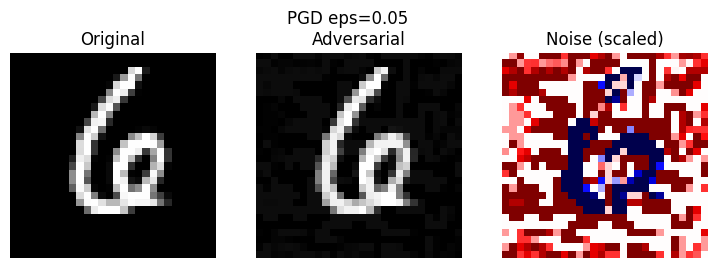

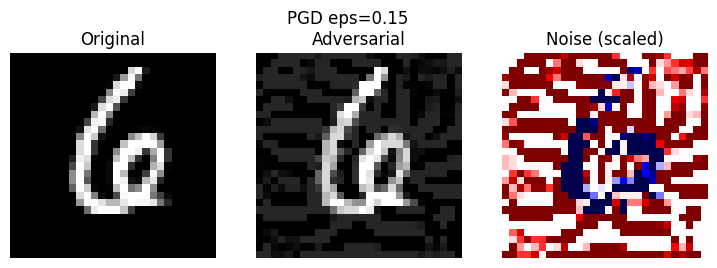

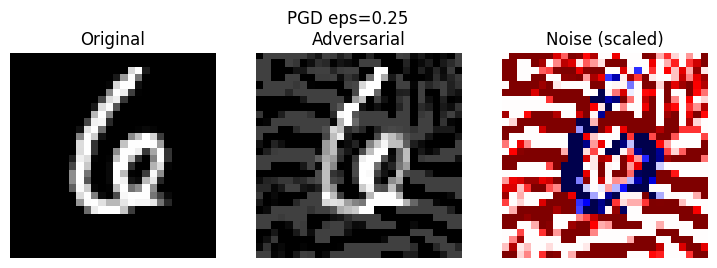


Saved all CSVs and results to: outputs_adv
Files saved: clean_vs_adv_table.csv, transferability.csv, pgd_steps_ablation.csv


In [ ]:
def robust_eval(model, loader, eps, iters):
    model.eval()
    total, correct = 0, 0
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        # Craft adversarial examples outside no_grad context
        xadv = pgd_attack(model, x, y, eps=eps, alpha=PGD_ALPHA, iters=iters, targeted=False)
        with torch.no_grad(): # Evaluate model on xadv inside no_grad
            out = model(xadv)
            preds = out.argmax(dim=1)
        total += x.size(0)
        correct += (preds == y).sum().item()
    return correct/total

# save adv-trained model
torch.save(model_adv.state_dict(), os.path.join(OUTPUT_DIR, "model_adv.pth"))

# ===== 7. Evaluate: clean, FGSM & PGD for both models across EPS_LIST =====
def eval_attack_on_loader(model, loader, attack_fn, eps, targeted=False, target_fn=None, iters=PGD_STEPS):
    model.eval()
    total, correct_orig = 0, 0
    total_target_correct = 0
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        # Craft adversarial examples outside no_grad
        if targeted:
            target_labels = target_fn(y)
            xadv = attack_fn(model, x, y, eps, targeted=True, target_label=target_labels) if attack_fn==fgsm_batch else attack_fn(model, x, y, eps, targeted=True, target_label=target_labels, iters=iters)
        else:
            xadv = attack_fn(model, x, y, eps, targeted=False) if attack_fn==fgsm_batch else attack_fn(model, x, y, eps, targeted=False, iters=iters)

        with torch.no_grad(): # Evaluate model on xadv inside no_grad
            out = model(xadv)
            preds = out.argmax(dim=1)
        total += x.size(0)
        correct_orig += (preds == y).sum().item()
        if targeted:
            total_target_correct += (preds == target_labels.to(DEVICE)).sum().item()
    acc_orig = correct_orig/total
    acc_target = (total_target_correct/total) if targeted else None
    return acc_orig, acc_target

def next_label(y):
    return ((y + 1) % 10).to(torch.long)

def evaluate_models(models, labels):
    # models: dict name -> model
    results = {}
    for name, m in models.items():
        results[name] = {}
        # clean acc
        _, clean_acc = eval_model(m, test_loader, DEVICE)
        results[name]['clean_acc'] = clean_acc
        # FGSM and PGD
        for eps in EPS_LIST:
            fgsm_acc, fgsm_target = eval_attack_on_loader(m, test_loader, fgsm_batch, eps, targeted=False)
            pgd_acc, pgd_target = eval_attack_on_loader(m, test_loader, pgd_batch, eps, targeted=False, iters=PGD_STEPS)
            results[name][f'fgsm_eps_{eps}'] = fgsm_acc
            results[name][f'pgd_eps_{eps}']  = pgd_acc
        # targeted PGD success (on same model) for reporting
        for eps in EPS_LIST:
            _, pgd_target_success = eval_attack_on_loader(m, test_loader, pgd_batch, eps, targeted=True, target_fn=next_label, iters=PGD_STEPS)
            results[name][f'pgd_target_success_eps_{eps}'] = pgd_target_success
    return results

models = {"clean": model_clean, "adv_trained": model_adv}
print("\n=== Evaluating baseline and adv-trained models ===")
res = evaluate_models(models, None)
df_rows = []
for name in res:
    row = {"Model": name, "Clean Acc": res[name]['clean_acc']}
    for eps in EPS_LIST:
        row[f'FGSM eps={eps}'] = res[name][f'fgsm_eps_{eps}']
        row[f'PGD eps={eps}']  = res[name][f'pgd_eps_{eps}']
        row[f'PGD_target_success_eps={eps}'] = res[name][f'pgd_target_success_eps_{eps}']
    df_rows.append(row)
df = pd.DataFrame(df_rows)
print(df)
df.to_csv(os.path.join(OUTPUT_DIR, "clean_vs_adv_table.csv"), index=False)
print("Saved comparison CSV to outputs_adv/clean_vs_adv_table.csv")

# ===== 8. Transferability experiment =====
# For each eps, craft adversarial examples on model A and evaluate on model B.
def transferability_attack(source_model, target_model, eps, iters=PGD_STEPS):
    source_model.eval(); target_model.eval()
    total, success_on_target = 0, 0
    # We'll craft PGD adversarial examples on source_model (untargeted), then check whether target_model prediction != true label
    for x,y in test_loader: # Remove with torch.no_grad() from here
        x,y = x.to(DEVICE), y.to(DEVICE)
        # craft on source (need non-no-grad)
        x_adv = pgd_attack(source_model, x, y, eps=eps, alpha=PGD_ALPHA, iters=iters, targeted=False)
        with torch.no_grad(): # Apply no_grad only for the target model evaluation
            out_target = target_model(x_adv)
            preds = out_target.argmax(dim=1)
        total += x.size(0)
        success_on_target += (preds != y).sum().item()
    return success_on_target / total

print("\n=== Transferability (PGD crafted on source -> evaluate on target) ===")
transfer_results = []
for eps in EPS_LIST:
    t_clean_to_adv = transferability_attack(model_clean, model_adv, eps, iters=PGD_STEPS)
    t_adv_to_clean = transferability_attack(model_adv, model_clean, eps, iters=PGD_STEPS)
    print(f"EPS={eps}: clean->adv model transfer success: {t_clean_to_adv:.4f} | adv->clean transfer success: {t_adv_to_clean:.4f}")
    transfer_results.append({"eps": eps, "clean_to_adv": t_clean_to_adv, "adv_to_clean": t_adv_to_clean})
pd.DataFrame(transfer_results).to_csv(os.path.join(OUTPUT_DIR, "transferability.csv"), index=False)

# ===== 9. PGD-steps ablation (on baseline model) =====
print("\n=== PGD steps ablation on baseline model ===")
ablation_results = []
for steps in PGD_STEPS_LIST:
    acc_for_eps = {}
    for eps in EPS_LIST:
        acc, _ = eval_attack_on_loader(model_clean, test_loader, pgd_batch, eps, targeted=False, iters=steps)
        acc_for_eps[f'acc_eps_{eps}'] = acc
    row = {"steps": steps, **acc_for_eps}
    ablation_results.append(row)
ablation_df = pd.DataFrame(ablation_results)
ablation_df.to_csv(os.path.join(OUTPUT_DIR, "pgd_steps_ablation.csv"), index=False)
print(ablation_df)

# ===== 10. Visualize example perturbations at epsilons (single sample) =====
def show_triplets(x_orig, x_adv, title_prefix=""):
    x0 = x_orig.squeeze().cpu().numpy()
    xa = x_adv.squeeze().cpu().numpy()
    delta = xa - x0
    dmin, dmax = delta.min(), delta.max()
    if abs(dmax - dmin) < 1e-12:
        delta_vis = np.zeros_like(delta)
    else:
        delta_vis = (delta - dmin) / (dmax - dmin)
    fig,ax = plt.subplots(1,3, figsize=(9,3))
    ax[0].imshow(x0, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
    ax[1].imshow(xa, cmap='gray'); ax[1].set_title("Adversarial"); ax[1].axis('off')
    ax[2].imshow(delta_vis, cmap='seismic'); ax[2].set_title("Noise (scaled)"); ax[2].axis('off')
    plt.suptitle(title_prefix)
    plt.show()

# pick sample index
SAMPLE_INDEX = 123
x_s, y_s = test_ds[SAMPLE_INDEX]
x_s = x_s.unsqueeze(0).to(DEVICE); y_tens = torch.tensor([y_s]).to(DEVICE)

for eps in EPS_LIST:
    x_pgd = pgd_attack(model_clean, x_s, y_tens, eps=eps, alpha=PGD_ALPHA, iters=PGD_STEPS)
    show_triplets(x_s.cpu(), x_pgd.cpu(), title_prefix=f"PGD eps={eps}")

# ===== 11. Final prints and saved outputs =====
print("\nSaved all CSVs and results to:", OUTPUT_DIR)
print("Files saved: clean_vs_adv_table.csv, transferability.csv, pgd_steps_ablation.csv")

In [ ]:
"""
Adversarial Training on CIFAR-10 with FGSM and PGD Attacks

This notebook demonstrates:
1. Training a baseline model on CIFAR-10
2. Implementing FGSM and PGD attacks
3. Adversarial training with both attacks
4. Comprehensive evaluation and comparison
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [ ]:
# ============================================================================
# 1. SETUP AND CONFIGURATION
# ============================================================================

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
NUM_CLASSES = 10

# Attack parameters
EPSILON = 8/255  # Standard CIFAR-10 epsilon
ALPHA_FGSM = EPSILON
ALPHA_PGD = 2/255
PGD_STEPS = 7

# ============================================================================
# 2. DATA LOADING
# ============================================================================

# Data preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# ============================================================================
# 3. MODEL ARCHITECTURE
# ============================================================================

class ResidualBlock(nn.Module):
    """Basic residual block for ResNet"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18(nn.Module):
    """ResNet-18 for CIFAR-10"""
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# ============================================================================
# 4. ATTACK IMPLEMENTATIONS
# ============================================================================

def fgsm_attack(model, images, labels, epsilon):
    """
    Fast Gradient Sign Method (FGSM) attack

    Args:
        model: Neural network model
        images: Input images (batch)
        labels: True labels
        epsilon: Perturbation magnitude

    Returns:
        Adversarial examples
    """
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Create adversarial example
    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_image = images + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image.detach()

def pgd_attack(model, images, labels, epsilon, alpha, num_iter, random_start=True):
    """
    Projected Gradient Descent (PGD) attack

    Args:
        model: Neural network model
        images: Input images (batch)
        labels: True labels
        epsilon: Maximum perturbation (L-infinity bound)
        alpha: Step size
        num_iter: Number of iterations
        random_start: Whether to use random initialization

    Returns:
        Adversarial examples
    """
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    # Random initialization
    adv_images = images.clone().detach()
    if random_start:
        adv_images = adv_images + torch.empty_like(adv_images).uniform_(-epsilon, epsilon)
        adv_images = torch.clamp(adv_images, 0, 1)

    # Iterative attack
    for i in range(num_iter):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        model.zero_grad()
        loss.backward()

        # Update adversarial images
        grad_sign = adv_images.grad.data.sign()
        adv_images = adv_images.detach() + alpha * grad_sign

        # Project back to epsilon ball
        delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(images + delta, 0, 1).detach()

    return adv_images

# ============================================================================
# 5. TRAINING FUNCTIONS
# ============================================================================

def train_standard(model, train_loader, optimizer, epoch):
    """Standard training (no adversarial examples)"""
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': train_loss/total, 'acc': 100.*correct/total})

    return train_loss/len(train_loader), 100.*correct/total

def train_adversarial_fgsm(model, train_loader, optimizer, epoch, epsilon):
    """Adversarial training with FGSM"""
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch} (FGSM)')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples
        adv_images = fgsm_attack(model, images, labels, epsilon)

        # Train on adversarial examples
        optimizer.zero_grad()
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': train_loss/total, 'acc': 100.*correct/total})

    return train_loss/len(train_loader), 100.*correct/total

def train_adversarial_pgd(model, train_loader, optimizer, epoch, epsilon, alpha, steps):
    """
    Adversarial training with PGD
    """
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch} (PGD)')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples
        adv_images = pgd_attack(model, images, labels, epsilon, alpha, steps)

        # Train on adversarial examples
        optimizer.zero_grad()
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': train_loss/total, 'acc': 100.*correct/total})

    return train_loss/len(train_loader), 100.*correct/total

# ============================================================================
# 6. EVALUATION FUNCTIONS
# ============================================================================

def evaluate(model, test_loader, attack_fn=None, attack_params=None):
    """
    Evaluate model on clean or adversarial examples

    Args:
        model: Model to evaluate
        test_loader: Test data loader
        attack_fn: Attack function (None for clean evaluation)
        attack_params: Parameters for attack function

    Returns:
        accuracy: Test accuracy
    """
    model.eval()
    correct = 0
    total = 0

    for images, labels in tqdm(test_loader, desc='Evaluating'):
        images, labels = images.to(device), labels.to(device)

        if attack_fn is not None:
            # Generate adversarial examples outside no_grad
            # Temporarily set model to train mode to enable grad for attack if needed
            # (though fgsm_attack/pgd_attack internally ensure images have grad)
            model.train()
            images_to_evaluate = attack_fn(model, images, labels, **attack_params)
            model.eval() # Restore model to eval mode
        else:
            images_to_evaluate = images

        # Evaluate the model on the (potentially adversarial) images within no_grad
        with torch.no_grad():
            outputs = model(images_to_evaluate)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return accuracy

def comprehensive_evaluation(model, test_loader):
    """Evaluate model against multiple attacks"""
    print("\n" + "="*70)
    print("COMPREHENSIVE EVALUATION")
    print("="*70)

    # Clean accuracy
    clean_acc = evaluate(model, test_loader)
    print(f"Clean Accuracy: {clean_acc:.2f}%")

    # FGSM attack
    fgsm_acc = evaluate(model, test_loader, fgsm_attack,
                       {'epsilon': EPSILON})
    print(f"FGSM Attack (\u03B5={EPSILON:.3f}): {fgsm_acc:.2f}%")

    # PGD attack (7 steps)
    pgd7_acc = evaluate(model, test_loader, pgd_attack,
                       {'epsilon': EPSILON, 'alpha': ALPHA_PGD,
                        'num_iter': 7, 'random_start': True})
    print(f"PGD-7 Attack (\u03B5={EPSILON:.3f}): {pgd7_acc:.2f}%")

    # PGD attack (20 steps - stronger)
    pgd20_acc = evaluate(model, test_loader, pgd_attack,
                        {'epsilon': EPSILON, 'alpha': ALPHA_PGD,
                         'num_iter': 20, 'random_start': True})
    print(f"PGD-20 Attack (\u03B5={EPSILON:.3f}): {pgd20_acc:.2f}%")

    print("="*70 + "\n")

    return {
        'clean': clean_acc,
        'fgsm': fgsm_acc,
        'pgd7': pgd7_acc,
        'pgd20': pgd20_acc
    }

# ============================================================================
# 7. VISUALIZATION FUNCTIONS
# ============================================================================

def visualize_adversarial_examples(model, test_loader, num_examples=5):
    """Visualize original and adversarial examples"""
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_examples].to(device), labels[:num_examples].to(device)

    # Generate adversarial examples
    fgsm_adv = fgsm_attack(model, images, labels, EPSILON)
    pgd_adv = pgd_attack(model, images, labels, EPSILON, ALPHA_PGD, 7)

    # Get predictions
    with torch.no_grad():
        clean_pred = model(images).argmax(dim=1)
        fgsm_pred = model(fgsm_adv).argmax(dim=1)
        pgd_pred = model(pgd_adv).argmax(dim=1)

    # Plot
    fig, axes = plt.subplots(3, num_examples, figsize=(15, 9))

    for i in range(num_examples):
        # Original
        axes[0, i].imshow(images[i].cpu().permute(1, 2, 0))
        axes[0, i].set_title(f'Clean\nTrue: {classes[labels[i]]}\nPred: {classes[clean_pred[i]]}')
        axes[0, i].axis('off')

        # FGSM
        axes[1, i].imshow(fgsm_adv[i].cpu().permute(1, 2, 0))
        axes[1, i].set_title(f'FGSM\nPred: {classes[fgsm_pred[i]]}')
        axes[1, i].axis('off')

        # PGD
        axes[2, i].imshow(pgd_adv[i].cpu().permute(1, 2, 0))
        axes[2, i].set_title(f'PGD-7\nPred: {classes[pgd_pred[i]]}')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.savefig('adversarial_examples.png', dpi=150, bbox_inches='tight')
    print("Saved adversarial examples to 'adversarial_examples.png'")
    plt.show()

def plot_training_comparison(results_dict):
    """Plot comparison of different training methods"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    models = list(results_dict.keys())
    metrics = ['clean', 'fgsm', 'pgd7', 'pgd20']
    metric_names = ['Clean', 'FGSM', 'PGD-7', 'PGD-20']

    x = np.arange(len(metrics))
    width = 0.25

    for idx, model_name in enumerate(models):
        values = [results_dict[model_name][m] for m in metrics]
        axes[0].bar(x + idx*width, values, width, label=model_name)

    axes[0].set_xlabel('Attack Type')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title('Model Robustness Comparison')
    axes[0].set_xticks(x + width)
    axes[0].set_xticklabels(metric_names)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # Robustness vs Clean accuracy trade-off
    clean_accs = [results_dict[m]['clean'] for m in models]
    robust_accs = [results_dict[m]['pgd20'] for m in models]

    axes[1].scatter(clean_accs, robust_accs, s=200, alpha=0.6)
    for i, model_name in enumerate(models):
        axes[1].annotate(model_name, (clean_accs[i], robust_accs[i]),
                        xytext=(5, 5), textcoords='offset points')

    axes[1].set_xlabel('Clean Accuracy (%)')
    axes[1].set_ylabel('Robust Accuracy (PGD-20) (%)')
    axes[1].set_title('Clean vs Robust Accuracy Trade-off')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight')
    print("Saved comparison plot to 'training_comparison.png'")
    plt.show()

Using device: cuda
Loading CIFAR-10 dataset...
Training samples: 50000
Test samples: 10000


In [ ]:
# ============================================================================
# 8. MAIN TRAINING PIPELINE
# ============================================================================

def main():
    print("\n" + "="*70)
    print("ADVERSARIAL TRAINING ON CIFAR-10")
    print("="*70 + "\n")

    results = {}

    # ========================================================================
    # Train Standard Model (Baseline)
    # ========================================================================
    print("\n>>> Training Standard Model (No Adversarial Training)")
    print("-"*70)

    model_standard = ResNet18().to(device)
    optimizer = optim.Adam(model_standard.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

    for epoch in range(1, NUM_EPOCHS + 1):
        train_standard(model_standard, train_loader, optimizer, epoch)
        scheduler.step()

    results['Standard'] = comprehensive_evaluation(model_standard, test_loader)
    torch.save(model_standard.state_dict(), 'model_standard.pth')

    # ========================================================================
    # Train with FGSM Adversarial Training
    # ========================================================================
    print("\n>>> Training with FGSM Adversarial Training")
    print("-"*70)

    model_fgsm = ResNet18().to(device)
    optimizer = optim.Adam(model_fgsm.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

    for epoch in range(1, NUM_EPOCHS + 1):
        train_adversarial_fgsm(model_fgsm, train_loader, optimizer, epoch, EPSILON)
        scheduler.step()

    results['FGSM-Trained'] = comprehensive_evaluation(model_fgsm, test_loader)
    torch.save(model_fgsm.state_dict(), 'model_fgsm.pth')

    # ========================================================================
    # Train with PGD Adversarial Training
    # ========================================================================
    print("\n>>> Training with PGD Adversarial Training")
    print("-"*70)

    model_pgd = ResNet18().to(device)
    optimizer = optim.Adam(model_pgd.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

    for epoch in range(1, NUM_EPOCHS + 1):
        train_adversarial_pgd(model_pgd, train_loader, optimizer, epoch,
                             EPSILON, ALPHA_PGD, PGD_STEPS)
        scheduler.step()

    results['PGD-Trained'] = comprehensive_evaluation(model_pgd, test_loader)
    torch.save(model_pgd.state_dict(), 'model_pgd.pth')

    # ========================================================================
    # Final Comparison and Visualization
    # ========================================================================
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        for metric, value in metrics.items():
            print(f"  {metric:10s}: {value:6.2f}%")

    # Visualizations
    print("\n>>> Generating visualizations...")
    visualize_adversarial_examples(model_standard, test_loader)
    plot_training_comparison(results)

    print("\n" + "="*70)
    print("TRAINING COMPLETE!")
    print("="*70)
    print("\nSaved models:")
    print("  - model_standard.pth")
    print("  - model_fgsm.pth")
    print("  - model_pgd.pth")
    print("\nSaved visualizations:")
    print("  - adversarial_examples.png")
    print("  - training_comparison.png")


ADVERSARIAL TRAINING ON CIFAR-10


>>> Training Standard Model (No Adversarial Training)
----------------------------------------------------------------------


Epoch 20: 100%|██████████| 391/391 [00:41<00:00,  9.35it/s, loss=0.0011, acc=95.1]



COMPREHENSIVE EVALUATION


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.91it/s]


Clean Accuracy: 90.74%


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.55it/s]


FGSM Attack (ε=0.031): 30.81%


Evaluating: 100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


PGD-7 Attack (ε=0.031): 0.05%


Evaluating: 100%|██████████| 79/79 [02:40<00:00,  2.03s/it]


PGD-20 Attack (ε=0.031): 0.00%


>>> Training with FGSM Adversarial Training
----------------------------------------------------------------------


Epoch 20 (FGSM): 100%|██████████| 391/391 [01:20<00:00,  4.83it/s, loss=0.00981, acc=51]



COMPREHENSIVE EVALUATION


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.53it/s]


Clean Accuracy: 74.28%


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.58it/s]


FGSM Attack (ε=0.031): 47.36%


Evaluating: 100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


PGD-7 Attack (ε=0.031): 43.38%


Evaluating: 100%|██████████| 79/79 [02:39<00:00,  2.02s/it]


PGD-20 Attack (ε=0.031): 40.80%


>>> Training with PGD Adversarial Training
----------------------------------------------------------------------


Epoch 20 (PGD): 100%|██████████| 391/391 [05:16<00:00,  1.23it/s, loss=0.0103, acc=49.2]



COMPREHENSIVE EVALUATION


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.83it/s]


Clean Accuracy: 73.31%


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.62it/s]


FGSM Attack (ε=0.031): 46.91%


Evaluating: 100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


PGD-7 Attack (ε=0.031): 43.84%


Evaluating: 100%|██████████| 79/79 [02:39<00:00,  2.02s/it]

PGD-20 Attack (ε=0.031): 41.60%


FINAL RESULTS SUMMARY

Standard:
  clean     :  90.74%
  fgsm      :  30.81%
  pgd7      :   0.05%
  pgd20     :   0.00%

FGSM-Trained:
  clean     :  74.28%
  fgsm      :  47.36%
  pgd7      :  43.38%
  pgd20     :  40.80%

PGD-Trained:
  clean     :  73.31%
  fgsm      :  46.91%
  pgd7      :  43.84%
  pgd20     :  41.60%

>>> Generating visualizations...


Saved adversarial examples to 'adversarial_examples.png'


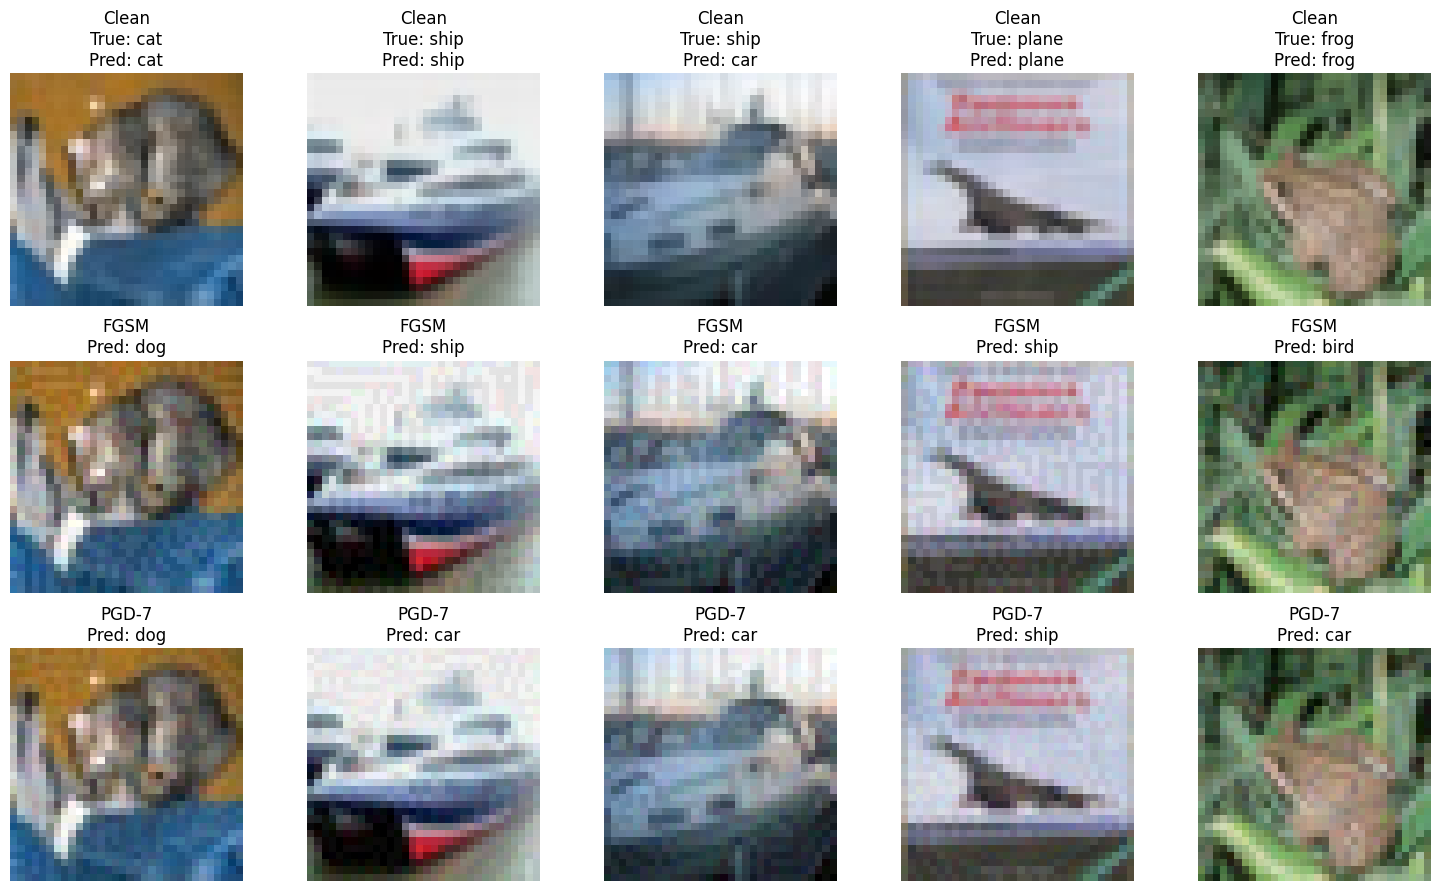

Saved comparison plot to 'training_comparison.png'


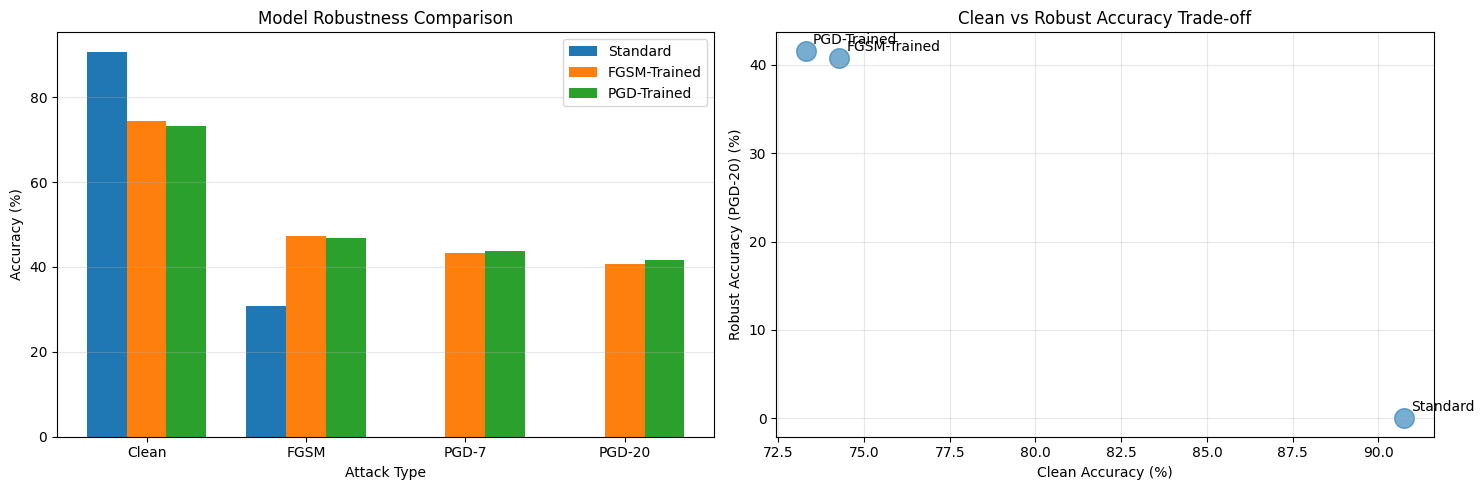


TRAINING COMPLETE!

Saved models:
  - model_standard.pth
  - model_fgsm.pth
  - model_pgd.pth

Saved visualizations:
  - adversarial_examples.png
  - training_comparison.png


In [ ]:
# ============================================================================
# 9. RUN THE EXPERIMENT
# ============================================================================

if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    # Run main training pipeline
    main()

Loading saved models...
Evaluating models...

COMPREHENSIVE EVALUATION


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 28.96it/s]


Clean Accuracy: 83.25%


Evaluating: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


FGSM Attack (ε=0.031): 30.86%


Evaluating: 100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


PGD-7 Attack (ε=0.031): 0.05%


Evaluating: 100%|██████████| 79/79 [02:40<00:00,  2.03s/it]


PGD-20 Attack (ε=0.031): 0.00%


COMPREHENSIVE EVALUATION


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.73it/s]


Clean Accuracy: 70.68%


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.60it/s]


FGSM Attack (ε=0.031): 46.78%


Evaluating: 100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


PGD-7 Attack (ε=0.031): 43.38%


Evaluating: 100%|██████████| 79/79 [02:39<00:00,  2.02s/it]


PGD-20 Attack (ε=0.031): 40.83%


COMPREHENSIVE EVALUATION


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.77it/s]


Clean Accuracy: 69.36%


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.63it/s]


FGSM Attack (ε=0.031): 46.37%


Evaluating: 100%|██████████| 79/79 [00:57<00:00,  1.38it/s]


PGD-7 Attack (ε=0.031): 43.82%


Evaluating: 100%|██████████| 79/79 [02:39<00:00,  2.02s/it]

PGD-20 Attack (ε=0.031): 41.64%

Generating plots...


Saved adversarial examples to 'adversarial_examples.png'


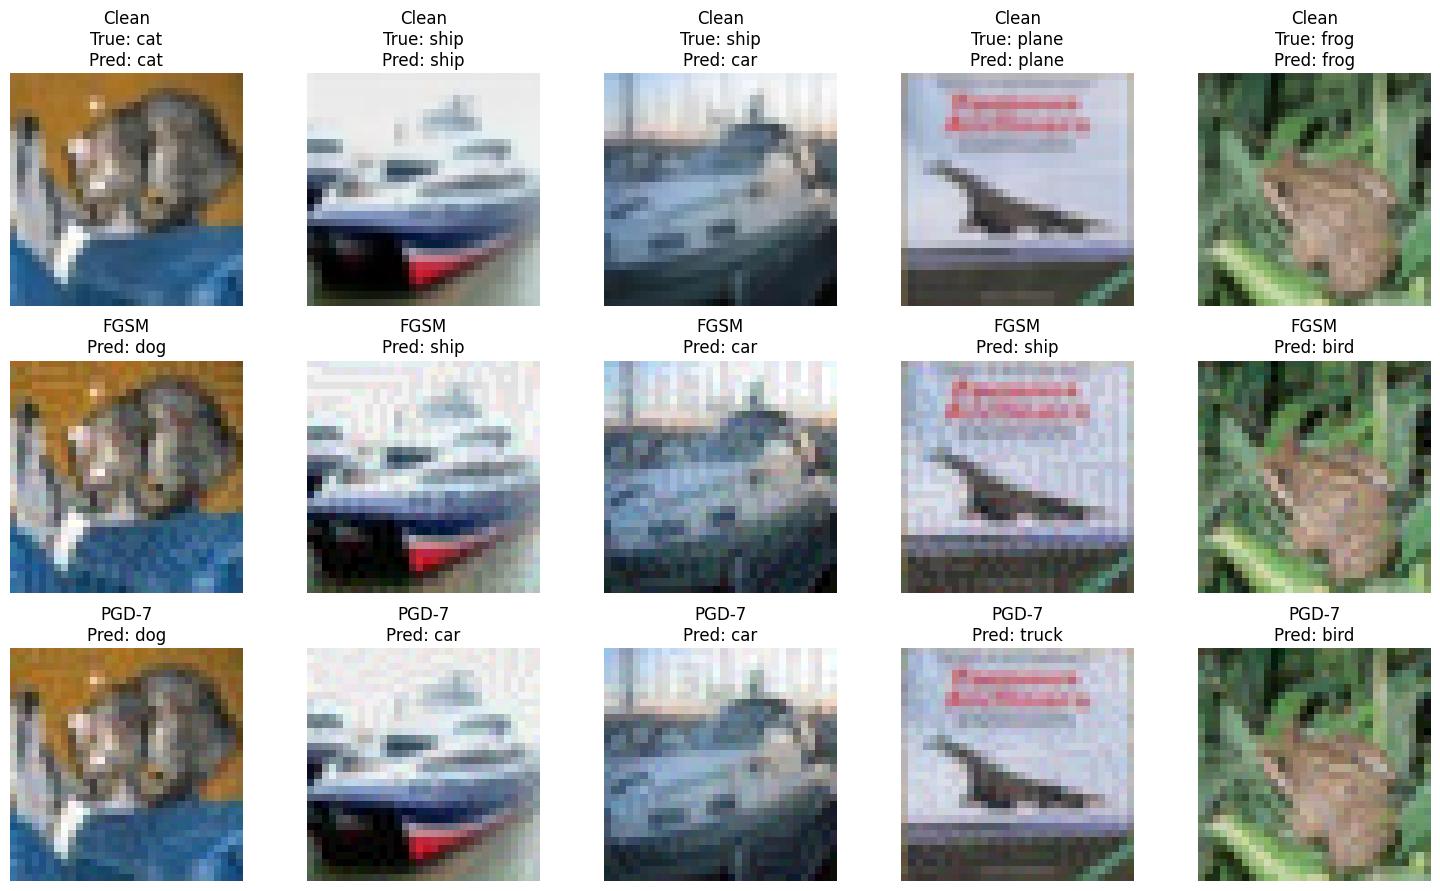

Saved comparison plot to 'training_comparison.png'


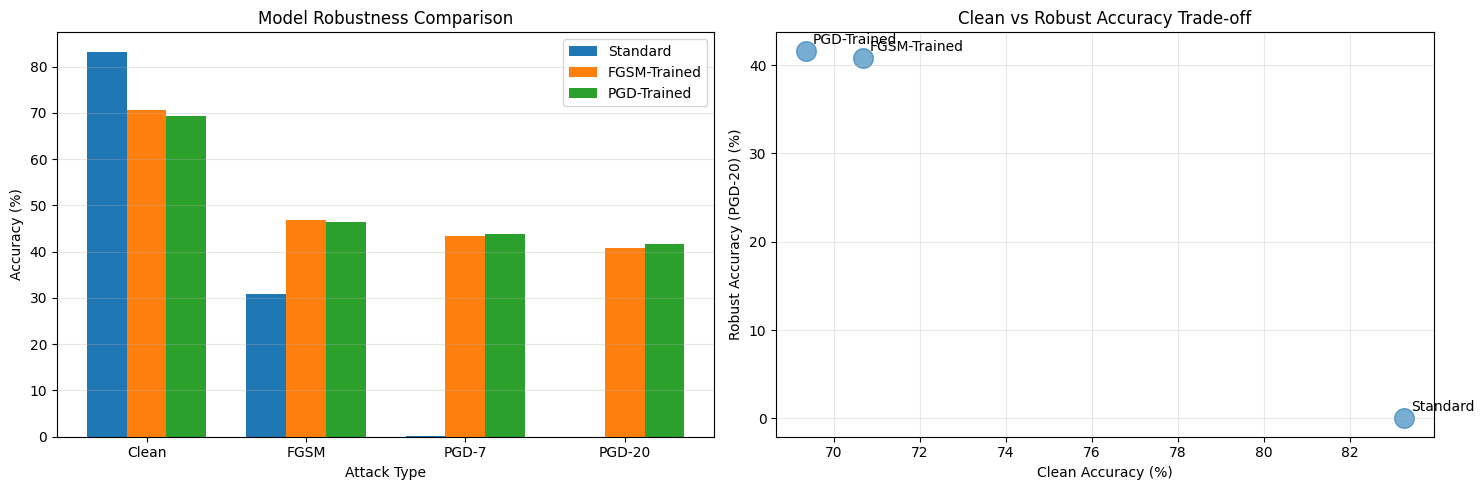

Done! Plots saved.


In [ ]:
import torch

# Assuming the following are already defined:
# ResNet18, comprehensive_evaluation, visualize_adversarial_examples,
# plot_training_comparison, device, test_loader

def regenerate_plots():

    print("Loading saved models...")

    model_standard = ResNet18().to(device)
    model_standard.load_state_dict(torch.load('model_standard.pth'))
    model_standard.eval()

    model_fgsm = ResNet18().to(device)
    model_fgsm.load_state_dict(torch.load('model_fgsm.pth'))
    model_fgsm.eval()

    model_pgd = ResNet18().to(device)
    model_pgd.load_state_dict(torch.load('model_pgd.pth'))
    model_pgd.eval()

    print("Evaluating models...")
    results = {
        'Standard': comprehensive_evaluation(model_standard, test_loader),
        'FGSM-Trained': comprehensive_evaluation(model_fgsm, test_loader),
        'PGD-Trained': comprehensive_evaluation(model_pgd, test_loader)
    }

    print("Generating plots...")
    visualize_adversarial_examples(model_standard, test_loader)
    plot_training_comparison(results)

    print("Done! Plots saved.")

regenerate_plots()
